# Fashion MNIST classification using PyTorch

In this notebook we will try to classify the Fashion MNIST dataset
(https://github.com/zalandoresearch/fashion-mnist) using CNN. 

## Fashion MNIST

This 10 class dataset is a drop-in replacement for MNIST with clothes instead of digits. Fashion MNIST is subtancially harder to classify.

![fashion_mnist](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.cm import get_cmap
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torchvision.transforms import transforms

Some system/model hyper parameters

In [2]:
cuda = False  # We don't use GPU for now.
batch_size = 128 # 60000/128 = 469. In fact There are 128 X 469 = 60032 spaces(32 empty spaces will be zero)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [3]:
english_labels = ["T-shirt/top",
                  "Trouser",
                  "Pullover",
                  "Dress",
                  "Coat",
                  "Sandal",
                  "Shirt",
                  "Sneaker",
                  "Bag",
                  "Ankle boot"]
# Get the data to train and put it in the variable train_data
train_data = datasets.FashionMNIST('data', train=True, download=True,
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                   ]))
# The train_loader has train_batch and train_target, and each size is torch.size(train_batch and train_target) => 128 label
train_loader = DataLoader(train_data, batch_size=128, shuffle=False, **kwargs)# Use to divide data into smaller pieces

Lets's compute the average mean and std of the train images. We will
use them for normalizing data later on.

In [75]:
n_samples_seen = 0.
mean = 0
std = 0  # Standard Deviation
for train_batch, train_target in train_loader: 
    batch_size = train_batch.shape[0] # train_batch.shape => ( batch size = 128, channel = 1,image_size = 28, 28)
    train_batch = train_batch.view(batch_size, -1) # 28 x 28 pixels into 784 single-line data
    this_mean = torch.mean(train_batch, dim=1) # Average the values of train_batch stretched in one line
    this_std = torch.sqrt(
        torch.mean((train_batch - this_mean[:, None]) ** 2, dim=1)) # Average the square of the train_batch minus this_mean (SD)
    mean += torch.sum(this_mean, dim=0)
    std += torch.sum(this_std, dim=0)
    n_samples_seen += batch_size

mean /= n_samples_seen
std /= n_samples_seen

In [76]:
print(mean, std)

tensor(0.2860) tensor(0.3202)


We now reload the data with a further `Normalize` transform

In [39]:
train_data = datasets.FashionMNIST('data', train=True, download=False, 
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=mean.view(1),
                                                            std=std.view(1))])) # I already downloaded it once, so download is false

test_data = datasets.FashionMNIST('data', train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean.view(1),
                                                           std=std.view(1))])) # Download is true because we need to get a data value

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, **kwargs) 
# batch_size = fixed to 32. Mix the images in the data


test_loader = torch.utils.data.DataLoader(test_data, batch_size=32,
                                          shuffle=False, **kwargs)
# In the test, there is no reason to mix the images in the data, so shuffle = false
# # Kwargs = known arguments


We define a very simple model, suitable for **CPU** training

In [90]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=(3, 3), padding=1) # Change 1 channel to 10 channels
        self.conv2 = nn.Conv2d(10, 20, kernel_size=(3, 3), padding=1) # Change 10 channels to 20 channels
        self.dropout_2d = nn.Dropout2d(p=0.25) # It randomly drops a quarter of all neurons
        self.fc1 = nn.Linear(7 * 7 * 20, 128) # to use in forward(), It receives 7*7*20 neurons in input size and 128 neurons in output size
        self.dropout = nn.Dropout(p=0.5) # It randomly drops half of the neurons in the whole neuron.
        self.fc2 = nn.Linear(128, 10) # The sample input size is 128 neurons and the output size is 10 neurons (in short, reduce the dimension)

    def forward(self, x):
        x = self.dropout_2d(F.max_pool2d(self.conv1(x), kernel_size=2)) # Using maxpool, the size of x is reduced by half. 10 x 14 x 14
        x = self.dropout_2d(F.max_pool2d(self.conv2(x), kernel_size=2)) # x becomes 20 x 7 x 7
        x = x.view(-1, 7 * 7 * 20)  # flatten / reshape
        x = F.relu(self.fc1(x)) # Replace all values below zero of x with zero.
        x = self.dropout(x) # Drop out half of all neurons in x
        x = self.fc2(x) # Through fc1(x), neurons with 128 outputs are reduced back to 10 neurons for the class.
        return F.log_softmax(x, dim=1) # Returns the probability values of multiple classes.

    def reset_parameters(self): # Reset all parameters
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()

In [91]:
# %load solutions/vgg.py

Let's test our model on CPU

In [92]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [93]:
model = Model()
img, target = train_data[0]
# n_channel, width, height
print(img.shape)

# First dimension should contain batch_size


torch.Size([1, 28, 28])


We can plot a training image

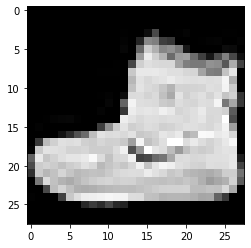

In [94]:
fig, ax = plt.subplots(1, 1)
ax.imshow(img[0].numpy(), cmap=get_cmap('gray'))
plt.show()


The first dimension of the input data should contain the batch size (due to `torch.nn` API)

In [95]:
# print(img)
print(img.shape)
print(img[None,:].shape)

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])


In [96]:
pred = model(img[None, :])
print(target, english_labels[target])
print(pred)

9 Ankle boot
tensor([[-2.4032, -2.1487, -2.2619, -2.2752, -2.2367, -2.4234, -2.2599, -2.3397,
         -2.3367, -2.3729]], grad_fn=<LogSoftmaxBackward0>)


We define a train loop

In [97]:
def train(model, optimizer, train_loader, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        batch_size = data.shape[0]
        optimizer.zero_grad() # Since the differential values are accumulated in the pytorch, the gradient is initialized so that it does not affect the next epoch
        output = model(data) 
        loss = F.nll_loss(output, target) # Check the difference between output and target.
        loss.backward() # It is differentiated by backpropagation and accumulated by calculating the influence (degree of change) of the parameter
        optimizer.step() # Update parameters to efficiently minimize loss function

        train_loss += loss.item() * batch_size

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss /= len(test_loader.dataset)
    return train_loss

And a test function:

In [100]:
def test(model, test_loader):
    model.eval() # Allow all layers of the model to enter evaluation mode (Batchnorm, Dropout disabled)
    test_loss = 0
    correct = 0
    with torch.no_grad(): # Disable auto gradient engine * Because the gradient is not calculated when performing inference or validation
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # sum up batch loss
            _, pred = output.data.max(dim=1)
            # get the index of the max log-probability
            correct += torch.sum(pred == target.data.long()).item()

        test_loss /= len(test_loader.dataset)
        test_accuracy = float(correct) / len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f},'
              ' Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * test_accuracy))
    return test_loss, test_accuracy

The `find_lr` function provides a learning rate for SGD or Adam, following heuristics from https://arxiv.org/abs/1506.01186:

In [101]:
import numpy as np

def loop_loader(data_loader):
    while True:
        for elem in data_loader:
            yield elem

            
def find_lr(model, train_loader, init_lr, max_lr, steps, n_batch_per_step=30):
    optimizer = torch.optim.SGD(model.parameters(), lr=init_lr)
    current_lr = init_lr
    best_lr = current_lr
    best_loss = float('inf')
    lr_step = (max_lr - init_lr) / steps

    loader = loop_loader(train_loader)
    for i in range(steps):
        mean_loss = 0
        n_seen_samples = 0
        for j, (data, target) in enumerate(loader):
            if j > n_batch_per_step:
                break
            optimizer.zero_grad()
            if cuda:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            mean_loss += loss.item() * data.shape[0]
            n_seen_samples += data.shape[0]
            optimizer.step()

        mean_loss /= n_seen_samples
        print('Step %i, current LR: %f, loss %f' % (i, current_lr, mean_loss))
            
        if np.isnan(mean_loss) or mean_loss > best_loss * 4:
            return best_lr / 4
        
        if mean_loss < best_loss:
            best_loss = mean_loss
            best_lr = current_lr

        current_lr += lr_step
        optimizer.param_groups[0]['lr'] = current_lr

    return best_lr / 4


Let's load our model on the GPU if required. We then define an optimizer and a learning rate scheduler

In [102]:
log_interval = 100
epochs = 12

In [103]:
if cuda:
    model.cuda()

model.reset_parameters()
lr = find_lr(model, train_loader, 1e-4, 1, 100, 30)
model.reset_parameters()

print('Best LR', lr)

Step 0, current LR: 0.000100, loss 2.303899
Step 1, current LR: 0.010099, loss 2.301278
Step 2, current LR: 0.020098, loss 2.286713
Step 3, current LR: 0.030097, loss 2.248201
Step 4, current LR: 0.040096, loss 2.071969
Step 5, current LR: 0.050095, loss 1.474836
Step 6, current LR: 0.060094, loss 1.108699
Step 7, current LR: 0.070093, loss 0.967082
Step 8, current LR: 0.080092, loss 0.889717
Step 9, current LR: 0.090091, loss 0.848577
Step 10, current LR: 0.100090, loss 0.809863
Step 11, current LR: 0.110089, loss 0.756772
Step 12, current LR: 0.120088, loss 0.732439
Step 13, current LR: 0.130087, loss 0.750090
Step 14, current LR: 0.140086, loss 0.688540
Step 15, current LR: 0.150085, loss 0.682899
Step 16, current LR: 0.160084, loss 0.651937
Step 17, current LR: 0.170083, loss 0.627905
Step 18, current LR: 0.180082, loss 0.613022
Step 19, current LR: 0.190081, loss 0.625852
Step 20, current LR: 0.200080, loss 0.592693
Step 21, current LR: 0.210079, loss 0.579837
Step 22, current LR:

Let's train our model:

In [104]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                       T_max=3,
                                                       last_epoch=-1)

logs = {'epoch': [], 'train_loss': [], 'test_loss': [],
        'test_accuracy': [], 'lr': []}

In [105]:
for epoch in range(epochs):
    train_loss = train(model, optimizer, train_loader, epoch)
    test_loss, test_accuracy = test(model, test_loader)
    logs['epoch'].append(epoch)
    logs['train_loss'].append(train_loss)
    logs['test_loss'].append(test_loss)
    logs['test_accuracy'].append(test_accuracy)
    logs['lr'].append(optimizer.param_groups[0]['lr'])
    scheduler.step(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309681
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.763211
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.604186
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.534887
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.584089


/home/elasticegg/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.1224, Accuracy: 7823/10000 (78%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.446541


/home/elasticegg/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.484069
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.405085
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.480263
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.582012

Test set: Average loss: 0.6173, Accuracy: 8393/10000 (84%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.321320
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.358608
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.402168
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.352891
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.511451

Test set: Average loss: 0.5541, Accuracy: 8533/10000 (85%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.279254
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.240115
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.289286
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.416934
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.497498

Test set: Average loss: 0.4907, Accuracy: 8607/10000 (86%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.251448
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.254583
Train Epoch: 5 [25600/60000 (43%

## Exercices

- Define a VGG or ResNet model, and train your network using **GPU**.
- (optional) Try data augmentation (horizontal flips, random crops, cutout...);
- (optional) Try to use batch-normalization;
- (optional) Implement skip-connections.

See how you compare to other approaches:
- https://github.com/zalandoresearch/fashion-mnist
- https://www.kaggle.com/zalando-research/fashionmnist

In [107]:
import torchvision
from torch.utils.tensorboard import SummaryWriter
class FashionMNISTResNet(nn.Module):
    def __init__(self, in_channels=1):
        super(FashionMNISTResNet, self).__init__()
        self.model = torchvision.models.resnet50(pretrained=True)
        # changing the input color channels to 1 since original resnet has 3 channels for RGB
        self.model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        
        num_ftrs = self.model.fc.in_features # which is 1000
        self.model.fc = nn.Linear(num_ftrs, 10)

    def forward(self, t):
#         print("Input shape",t.shape)
#         print("Output shape",self.model(t).shape)
        return self.model(t)


def get_num_correct_predictions(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()


lr = 0.001
acc = []
fin_acc = []
ep = []

network = FashionMNISTResNet()

images, labels = next(iter(train_loader))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device : ", device)
network.to(device)

network = FashionMNISTResNet()

optimizer = torch.optim.Adam(network.parameters(), lr=lr)

for epoch in range(5):

    total_loss = 0
    total_correct = 0
    total_test_loss = 0
    total_test_correct = 0
    for batch in train_loader:
        images, labels = batch 
        if torch.cuda.is_available():
            images = images.to(device)
            labels = labels.to(device)
            network = network.to(device)

        preds = network(images)
#         print("pred? : ", preds.shape)
        loss = F.cross_entropy(preds, labels)
        loss=loss.cuda()
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()

        total_loss += loss.item() * batch_size 
        total_correct += get_num_correct_predictions(preds, labels)



    for test_batch in test_loader:
        test_images, test_labels = test_batch
        if torch.cuda.is_available():
            test_images = test_images.to(device)
            test_labels = test_labels.to(device)
        test_preds = network(test_images)

        total_test_correct += get_num_correct_predictions(test_preds, test_labels)

    accuracy = total_correct / len(train_data) * 100
    acc.append(accuracy)
    test_accuracy = total_test_correct / len(test_data) * 100
    print("epoch:", epoch, "total_correct:", total_correct, "loss:", total_loss, "Training Accuracy:", accuracy,'%', "Test Accuracy:", test_accuracy,'%')
fin_acc.append(accuracy)
print("Learning_rate:", lr, "Accuracy:", accuracy)



device :  cuda:0
epoch: 0 total_correct: 50225 loss: 20417.919731140137 Training Accuracy: 83.70833333333333 % Test Accuracy: 85.26 %
epoch: 1 total_correct: 53497 loss: 13284.418697834015 Training Accuracy: 89.16166666666666 % Test Accuracy: 86.68 %
epoch: 2 total_correct: 54409 loss: 11334.963034629822 Training Accuracy: 90.68166666666667 % Test Accuracy: 86.92999999999999 %
epoch: 3 total_correct: 54748 loss: 10703.109285593033 Training Accuracy: 91.24666666666667 % Test Accuracy: 85.56 %


KeyboardInterrupt: 